In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [30]:
#Define all parameters
num_agents = 3
budgets = [100, 150, 200]
valuations = [0.8, 0.7, 0.6]
step_size = 0.025
time_horizon = 10000
upper_bound = 1.0
ctr = [0.2, 0.2, 0.2]

time_horizons = np.logspace(
    start=np.log10(1000),
    stop=np.log10(time_horizon),
    num=10
).astype(int)

In [31]:
class BudgetPacingUCBCTR:
    def __init__(self, num_agents, budgets, valuations, step_size, time_horizon, upper_bound, ctr):
        self.num_agents = num_agents
        self.budgets = np.array(budgets)
        self.valuations = np.array(valuations)
        self.step_size = step_size
        self.time_horizon = time_horizon
        self.upper_bound = upper_bound

        self.pacing_multipliers = np.zeros(self.num_agents)
        self.ctr_estimates = np.zeros(self.num_agents)
        self.click_counts = np.zeros(self.num_agents)
        self.impressions = np.ones(self.num_agents)
        self.remaining_budgets = self.budgets.copy()

        self.liquid_welfare = []
        self.allocations = np.zeros((self.num_agents, self.time_horizon)) 
        self.payments = np.zeros((self.num_agents, self.time_horizon)) 

        self.bid_history = []
        self.ctr = ctr

    def simulate_click(self, agent_idx):
        return np.random.random() < self.ctr[agent_idx]

    def run(self):
        for t in range(self.time_horizon):
            if t % 500 == 0:  # Print progress every 500 steps
                print(f"Main simulation progress: {t}/{self.time_horizon}")
            self.ctr_estimates = (
                self.click_counts / self.impressions +
                np.sqrt(3 * np.log(self.time_horizon) / (2 * self.impressions))
            )

            adjusted_values = self.valuations * self.ctr_estimates
            bids = np.array([
                min(
                    adjusted_values[k] / (1 + self.pacing_multipliers[k]),
                    self.remaining_budgets[k]
                )
                for k in range(self.num_agents)
            ])

            self.bid_history.append(bids)

            # Second price auction (lines 9-10)
            bid_scores = bids * self.ctr_estimates
            winner = np.argmax(bid_scores)
            sorted_indices = np.argsort(bid_scores)[::-1]
            second_highest_score = bid_scores[sorted_indices[1]]

            # Simulate if ad was clicked (for winner only)
            was_clicked = self.simulate_click(winner)
            click_indicator = 1 if was_clicked else 0

            payment = (
                second_highest_score / self.ctr_estimates[winner] * click_indicator
            )

            # Update winner's statistics (lines 14-15)
            self.impressions[winner] += 1
            if was_clicked:
                self.click_counts[winner] += 1
            
            # Update CTR estimate for winner
            self.ctr_estimates[winner] = (
                (1 - 1/self.impressions[winner]) * self.ctr_estimates[winner] +
                click_indicator/self.impressions[winner]
            )

            self.liquid_welfare.append(self.calculate_objective(self.allocations)[0])

             # Update pacing multipliers (line 17)
            for k in range(self.num_agents):
                if k == winner:
                    self.remaining_budgets[k] -= payment
                    self.pacing_multipliers[k] = max(
                        0,
                        min(
                            self.upper_bound,
                            self.pacing_multipliers[k] - self.step_size * (
                                self.budgets[k] / self.time_horizon - payment
                            )
                        )
                    )
                else:
                    # Non-winners don't update impressions or CTR estimates
                    self.pacing_multipliers[k] = max(
                        0,
                        min(
                            self.upper_bound,
                            self.pacing_multipliers[k] - self.step_size * (
                                self.budgets[k] / self.time_horizon - 0
                            )
                        )
                    )

            # Record allocation and payment
            self.allocations[winner, t] = click_indicator
            self.payments[winner, t] = payment

        return self.allocations

    def calculate_objective(self, allocations, λ=0):
        total_utility = 0
        utilities = np.zeros(self.num_agents)
        liquid_welfare = 0
        for agent in range(self.num_agents):
            total_value = sum(allocations[agent] * valuations[agent])
            liquid_welfare += min(budgets[agent], total_value)
            payments = sum(allocations[agent])  
            total_utility += total_value - payments
        return (1-λ) * liquid_welfare + (λ * total_utility), utilities


In [ ]:

# adding regret analysis stuff: 
def estimate_bid_distribution(agent_bid_history, agent_idx):
    """
    Estimate bid distribution for opponents from historical data.
    Returns parameters to generate synthetic bids.
    """
    opponent_bids = []
    for t in range(len(agent_bid_history)):
        # Collect all bids except agent_idx's
        for j in range(len(agent_bid_history[t])):
            if j != agent_idx:
                opponent_bids.append(agent_bid_history[t][j])
    
    # Fit distribution parameters
    mean = np.mean(opponent_bids)
    std = np.std(opponent_bids)
    return mean, std


def simulate_stochastic_fixed_multiplier(agent_idx, fixed_mu, valuations, budget, time_horizon, 
                                       bid_mean, bid_std, lambda_param=1, num_simulations=100):
    """
    Simulate what would happen if agent used fixed_mu in stochastic environment.
    Opponents' bids are drawn from estimated distribution.
    
    Args:
        lambda_param: Weight for spend penalty (0 for value maximization, >0 for utility)
                     Objective is: value - lambda_param * spend
    """
    total_objectives = []  # Store value - lambda * spend for each simulation
    num_opponents = len(valuations) - 1

    for sim in range(num_simulations):
        if sim % 20 == 0:  # Print every 20 simulations
            print(f"    Simulation progress: {sim}/{num_simulations}")
        remaining_budget = budget
        value = 0
        spend = 0
        
        for t in range(time_horizon):
            if remaining_budget <= 0:
                break
                
            # Generate opponents' bids from distribution
            opponent_bids = np.random.normal(bid_mean, bid_std, num_opponents)
            opponent_bids = np.maximum(opponent_bids, 0)  # Ensure non-negative
            
            # Calculate agent's bid with fixed multiplier
            agent_bid = min(
                valuations[agent_idx] / (1 + fixed_mu),
                remaining_budget
            )
            
            # Insert agent's bid
            all_bids = np.insert(opponent_bids, agent_idx, agent_bid)
            
            # Run second price auction
            sorted_bids = np.sort(all_bids)[::-1]
            winner = np.argmax(all_bids)
            
            # If agent won
            if winner == agent_idx:
                payment = sorted_bids[1]  # Second highest bid
                
                # Simulate click with constant CTR 
                if np.random.random() < ctr[agent_idx]: 
                    value += valuations[agent_idx]
                    spend += payment
                    remaining_budget -= payment
        
        # Calculate objective for this simulation
        objective = value - lambda_param * spend
        total_objectives.append(objective)
    
    # Return expected objective 
    return np.mean(total_objectives)

# Update the calling functions to include lambda parameter
def find_best_fixed_multiplier_grid(agent_idx, agent_bid_history, valuations, budget, 
                                  time_horizon, lambda_param=1, num_points=10):
    """Find the best fixed pacing multiplier using grid search."""
    print(f"\nSearching for best multiplier across {num_points} points...")
    bid_mean, bid_std = estimate_bid_distribution(agent_bid_history, agent_idx)
    
    multipliers = np.linspace(0, 1, num_points)
    best_objective = float('-inf')
    best_mu = 0
    
    for mu in multipliers:
        objective = simulate_stochastic_fixed_multiplier(
            agent_idx, mu, valuations, budget, time_horizon,
            bid_mean, bid_std, lambda_param
        )
        
        if objective > best_objective:
            best_objective = objective
            best_mu = mu
            
    return best_mu, best_objective

def calculate_stochastic_regret(simulator, agent_idx, time_horizon, lambda_param=1):
    """
    Calculate regret against stochastic benchmark.
    Uses value maximization when lambda_param=0, utility maximization otherwise.
    """
    # Get actual objective achieved
    actual_value = sum(simulator.allocations[agent_idx, :time_horizon] * 
                      simulator.valuations[agent_idx]) * ctr[agent_idx]
    actual_spend = sum(simulator.payments[agent_idx, :time_horizon])
    actual_objective = actual_value - lambda_param * actual_spend
    
    # Find best fixed multiplier for stochastic setting
    best_mu, optimal_objective = find_best_fixed_multiplier_grid(
        agent_idx,
        simulator.bid_history[:time_horizon],
        simulator.valuations,
        simulator.budgets[agent_idx],
        time_horizon,
        lambda_param
    )
    
    return max(0, optimal_objective - actual_objective)

def analyze_regret_over_time(simulator, time_horizons):
    """Calculate regret at different time horizons for all agents."""
    all_agents_regrets = []
    total_calculations = simulator.num_agents * len(time_horizons)
    current_calculation = 0
    
    print(f"\nStarting regret analysis across {simulator.num_agents} agents and {len(time_horizons)} time horizons...")
    
    for agent_idx in range(simulator.num_agents):
        print(f"\n{'='*50}")
        print(f"Processing Agent {agent_idx + 1}/{simulator.num_agents}")
        print(f"{'='*50}")
        
        agent_regrets = []
        for T in time_horizons:
            current_calculation += 1
            print(f"\nProgress: {current_calculation}/{total_calculations} calculations")
            print(f"Time horizon: {T}")
            
            regret = calculate_stochastic_regret(simulator, agent_idx, T, lambda_param=1)
            agent_regrets.append({
                'auctions': T,
                'regret': regret
            })
            
            print(f"Completed calculation {current_calculation}/{total_calculations}")
            print(f"Current regret for T={T}: {regret:.2f}")
        
        all_agents_regrets.append(agent_regrets)
        print(f"\nCompleted all calculations for Agent {agent_idx + 1}")
    
    print("\nRegret analysis complete!")
    return all_agents_regrets

def plot_regret_over_time(all_agents_regrets, title="Regret Evolution"):
    """Create log-log plot of regret evolution with detailed agent information."""
    plt.figure(figsize=(10, 6))
    
    # Different colors for each agent
    colors = ['red', 'purple', 'green']  # Explicit colors for each agent
    
    # Print agent information and plot
    for agent_idx, agent_regrets in enumerate(all_agents_regrets):
        auctions = [r['auctions'] for r in agent_regrets]
        regrets = [r['regret'] for r in agent_regrets]
        
        # Print agent details
        print(f"\nAgent {agent_idx}:")
        print(f"  Valuation: {valuations[agent_idx]}")
        print(f"  Budget: {budgets[agent_idx]}")
        print(f"  Color in plot: {colors[agent_idx]}")
        print(f"  Final regret: {regrets[-1]:.2f}")
        
        plt.loglog(auctions, regrets, '-', color=colors[agent_idx], 
                  label=f'Agent {agent_idx} (v={valuations[agent_idx]}, b={budgets[agent_idx]})', 
                  linewidth=2, alpha=0.7)
    
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlabel("# Auctions (Log)")
    plt.ylabel("Total Regret (Log)")
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Calculate and display slope
    all_log_auctions = []
    all_log_regrets = []
    for agent_regrets in all_agents_regrets:
        log_auctions = np.log([r['auctions'] for r in agent_regrets])
        log_regrets = np.log([max(1e-10, r['regret']) for r in agent_regrets])
        all_log_auctions.extend(log_auctions)
        all_log_regrets.extend(log_regrets)
    
    slope, _, _, _, std_err = stats.linregress(all_log_auctions, all_log_regrets)
    print(f"\nEstimated α (slope): {slope:.3f} (std err: {std_err:.4f})")
    
    plt.tight_layout()
    plt.show()

In [32]:
# Run main simulation
print("Starting main simulation...")
budget_pacing = BudgetPacingUCBCTR(
    num_agents=num_agents,
    budgets=budgets,
    valuations=valuations,
    step_size=step_size,
    time_horizon=time_horizon,
    upper_bound=upper_bound,
    ctr=ctr
)
results = budget_pacing.run()
print("Main simulation complete!")

Starting main simulation...
Main simulation progress: 0/10000
Main simulation progress: 500/10000
Main simulation progress: 1000/10000
Main simulation progress: 1500/10000
Main simulation progress: 2000/10000
Main simulation progress: 2500/10000
Main simulation progress: 3000/10000
Main simulation progress: 3500/10000
Main simulation progress: 4000/10000
Main simulation progress: 4500/10000
Main simulation progress: 5000/10000
Main simulation progress: 5500/10000
Main simulation progress: 6000/10000
Main simulation progress: 6500/10000
Main simulation progress: 7000/10000
Main simulation progress: 7500/10000
Main simulation progress: 8000/10000
Main simulation progress: 8500/10000
Main simulation progress: 9000/10000
Main simulation progress: 9500/10000
Main simulation complete!



Starting regret analysis across 3 agents and 10 time horizons...

Processing Agent 1/3

Progress: 1/30 calculations
Time horizon: 1000

Searching for best multiplier across 10 points...
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation pro

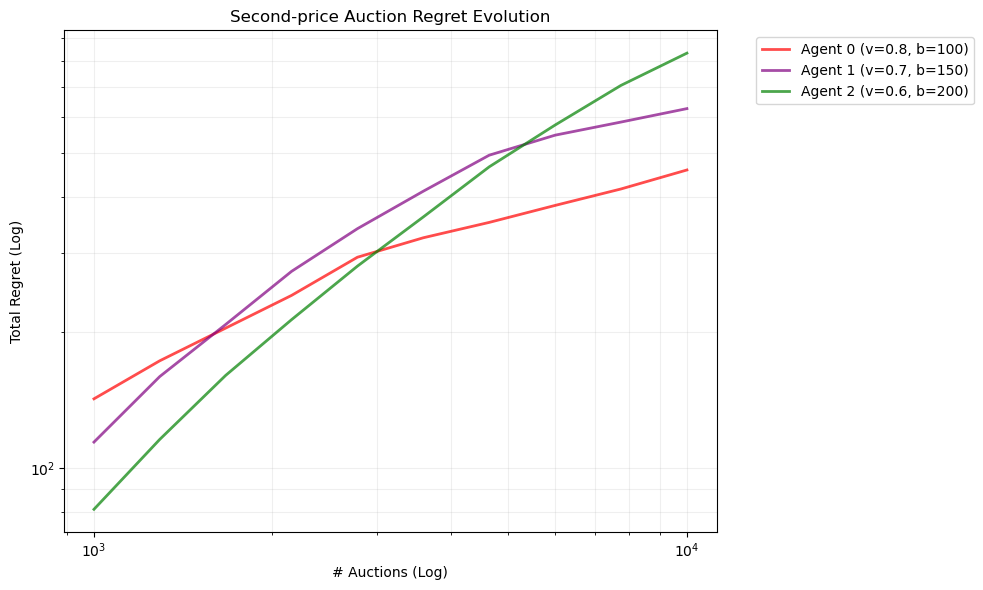

In [33]:
# For value maximization, lambda = 0
# Calculate regret over time 
regrets_over_time = analyze_regret_over_time(budget_pacing, time_horizons)

# Create plot for second-price auction 
plot_regret_over_time(regrets_over_time, "Second-price Auction Regret Evolution")


Starting regret analysis across 3 agents and 10 time horizons...

Processing Agent 1/3

Progress: 1/30 calculations
Time horizon: 1000

Searching for best multiplier across 10 points...
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation progress: 0/100
    Simulation progress: 20/100
    Simulation progress: 40/100
    Simulation progress: 60/100
    Simulation progress: 80/100
    Simulation pro

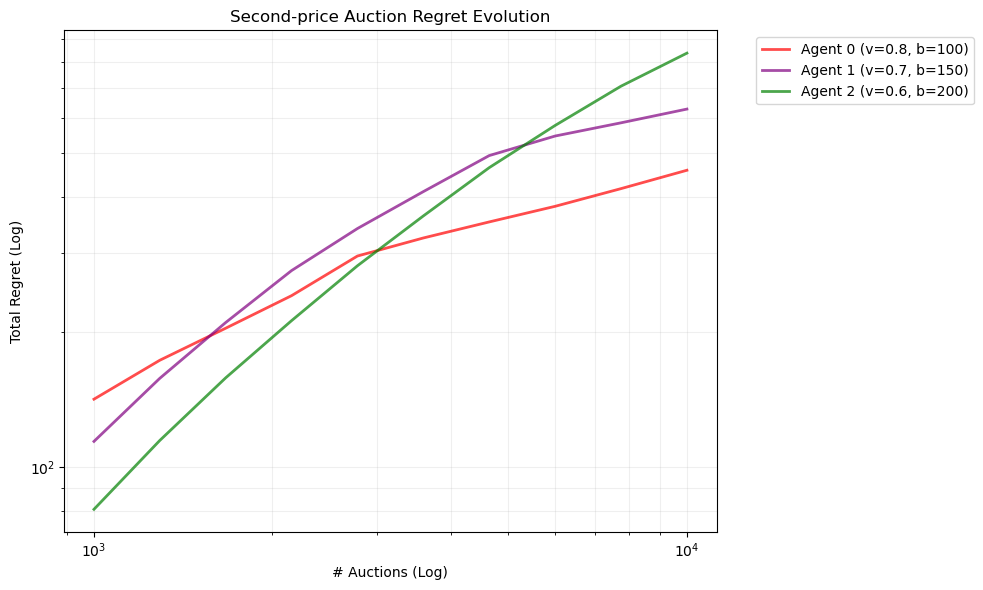

In [35]:
# For value maximization, lambda = 0
# Calculate regret over time 
regrets_over_time = analyze_regret_over_time(budget_pacing, time_horizons)

# Create plot for second-price auction 
plot_regret_over_time(regrets_over_time, "Second-price Auction Regret Evolution")